# Autoencoder for feature extraction

## Importing the libraries

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Importing the MNIST dataset

In [2]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train[:10000, :, :].reshape(10000, 28 * 28).astype(np.float32)
y_train = y_train[:10000]
X_test = X_test[:5000, :, :].reshape(5000, 28 * 28).astype(np.float32)
y_test = y_test[:5000]

In [4]:
# Rescaling the dataset to the range [0, 1]
X_train, X_test = X_train / 255., X_test / 255.

## Autoencoder using Tensorflow 2

### Parameters

In [5]:
# MNIST Dataset parameters.
n_features = 28 * 28 # data features (img shape: 28*28).

# Training parameters.
learning_rate = 0.01
training_steps = 30000
batch_size = 256
display_step = 1000

# Network Parameters
n_hidden_1 = 50 # 1st layer num features.
n_hidden_2 = 50 # 2nd layer num features.
n_hidden_3 = 5  # 3rd layer num features (the latent dim).

### Preparing the dataset

In [6]:
# Use tf.data API to shuffle and batch data.
# Prefetch batch (pre-load batch for faster consumption).
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.repeat().shuffle(10000).batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

### Autoencoder architecture

In [7]:
# Store layers weight & bias

# A random value generator to initialize weights.
random_normal = tf.initializers.RandomNormal()

weights = {
    'encoder_h1': tf.Variable(random_normal([n_features, n_hidden_1])),
    'encoder_h2': tf.Variable(random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(random_normal([n_hidden_2, n_hidden_3])),
    'decoder_h1': tf.Variable(random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h2': tf.Variable(random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(random_normal([n_hidden_1, n_features])),
}

biases = {
    'encoder_b1': tf.Variable(random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(random_normal([n_features])),
}

### Building the encoder and decoder

In [8]:
# Building the encoder.
def encoder(x):
    # Encoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    # Encoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    # Encoder Hidden layer with sigmoid activation
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']), biases['encoder_b3']))
    
    return layer_3

# Building the decoder.
def decoder(x):
    # Decoder Hidden layer with sigmoid activation
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    # Decoder Hidden layer with sigmoid activation
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']), biases['decoder_b3']))
    
    return layer_3

### Defining loss function and optimizer

In [9]:
# Mean square loss between the original and reconstructed images.
def mean_square(reconstructed, original):
    return tf.reduce_mean(tf.pow(original - reconstructed, 2))

# Adam optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

In [10]:
# Optimization process.
def run_optimization(x):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        reconstructed_image = decoder(encoder(x))
        loss = mean_square(reconstructed_image, x)
    
    # Variables to update, i.e. trainable variables.
    trainable_variables = list(weights.values()) + list(biases.values())
    
    # Compute gradients.
    gradients = g.gradient(loss, trainable_variables)
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss

### Fitting the autoencoder

In [11]:
# Run training for the given number of steps.
for step, (batch_x, _) in enumerate(train_data.take(training_steps + 1)):
    # Run the optimization.
    loss = run_optimization(batch_x)
    
    if step % display_step == 0:
        print('step: {}, loss: {}'.format(step, loss))

step: 0, loss: 0.2336382418870926
step: 1000, loss: 0.04881839454174042
step: 2000, loss: 0.037961699068546295
step: 3000, loss: 0.0350777730345726
step: 4000, loss: 0.03284522145986557
step: 5000, loss: 0.030538609251379967
step: 6000, loss: 0.030610745772719383
step: 7000, loss: 0.029539629817008972
step: 8000, loss: 0.029208241030573845
step: 9000, loss: 0.029208747670054436
step: 10000, loss: 0.029612138867378235
step: 11000, loss: 0.02892717346549034
step: 12000, loss: 0.02526942640542984
step: 13000, loss: 0.0270682405680418
step: 14000, loss: 0.02704431302845478
step: 15000, loss: 0.02686161734163761
step: 16000, loss: 0.02558109536767006
step: 17000, loss: 0.026357825845479965
step: 18000, loss: 0.024965768679976463
step: 19000, loss: 0.02558155357837677
step: 20000, loss: 0.024917688220739365
step: 21000, loss: 0.026445070281624794
step: 22000, loss: 0.02661667764186859
step: 23000, loss: 0.026081418618559837
step: 24000, loss: 0.026794463396072388
step: 25000, loss: 0.0240054

### Visualization of the result

Original Images


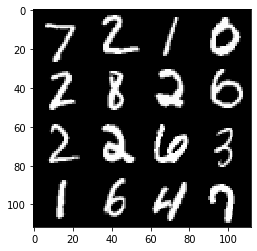

Reconstructed Images


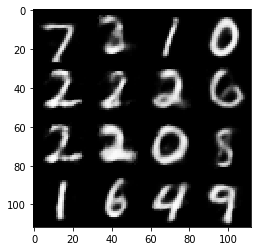

In [12]:
# Encode and decode images from test set and visualize their reconstruction.
n = 4
canvas_orig = np.empty((28 * n, 28 * n))
canvas_recon = np.empty((28 * n, 28 * n))
for i, (batch_x, _) in enumerate(test_data.take(n)):
    # Encode and decode the digit image.
    reconstructed_images = decoder(encoder(batch_x))
    # Display original images.
    for j in range(n):
        # Draw the generated digits.
        img = batch_x[j].numpy().reshape([28, 28])
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
    # Display reconstructed images.
    for j in range(n):
        # Draw the generated digits.
        reconstr_img = reconstructed_images[j].numpy().reshape([28, 28])
        canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = reconstr_img

print("Original Images")     
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()

print("Reconstructed Images")
plt.figure(figsize=(n, n))
plt.imshow(canvas_recon, origin="upper", cmap="gray")
plt.show()

## Feature extraction and fitting a simple classifier

In [13]:
encoder(X_test)

<tf.Tensor: id=4080844, shape=(5000, 5), dtype=float32, numpy=
array([[0.6126748 , 0.71319276, 0.51456094, 0.11920127, 0.03159794],
       [0.3056286 , 0.12274921, 0.6807954 , 0.34890732, 0.3171662 ],
       [0.31385303, 0.86651003, 0.80516243, 0.0294897 , 0.73221815],
       ...,
       [0.12385178, 0.46878108, 0.45296404, 0.4470287 , 0.34301698],
       [0.8557508 , 0.5599442 , 0.53159344, 0.12425762, 0.38883924],
       [0.26869315, 0.3754446 , 0.19658351, 0.9318118 , 0.06645679]],
      dtype=float32)>

In [14]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()

In [15]:
classifier.fit(encoder(X_train), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [16]:
accuracy = classifier.score(encoder(X_test), y_test)
print('Accuracy: {}%'.format(accuracy * 100))

Accuracy: 71.26%
